# <font color="#000099">llm-d-benchmarking Benchmark Analysis</font>

This notebook demonstrates usage of the configuration explorer library. The workflow starts by importing benchmark report data from configuration sweeps from [llm-d-benchmark](https://github.com/llm-d/llm-d-benchmark), and performs grouping, filtering, and plotting of the results.

While the basic functionality here may be sufficient for many purposes, this notebook should be considered a starting point for more detailed analysis and customization by the user.

## Import Python packages and load benchmark datasets

In [1]:
################################################################################
# User inputs
################################################################################

# List of directories containing benchmark sweeps to import.
search_dirs = [
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/PD/Sanitized/PD_Disaggregation/",
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/inf_sche/Sanitized/",
    "/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix/",
]

################################################################################
# Import packages
################################################################################

import explorer as xp
from plotting import plot_scenario, plot_scenario_tradeoff, plot_pareto_tradeoff

################################################################################
# Standard code
################################################################################

# TODO how to change building of dataframe to avoid warnins?
import warnings
warnings.filterwarnings(
    "ignore", 
    category=FutureWarning, 
    message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated."
)

# Create blank DataFrames for benchmarking runs
runs = xp.make_benchmark_runs_df()

# Populate the runs DataFrame
for sdir in search_dirs:
    print(f'Searching for benchmark report files within {sdir}')
    # Find all benchmark report files in the directory
    for br_file in xp.get_benchmark_report_files(sdir):
        #info(f'Importing {br_file}')
        # Import the results and add to the runs DataFrame
        xp.add_benchmark_report_to_df(runs, br_file)

Searching for benchmark report files within /files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/PD/Sanitized/PD_Disaggregation/
Searching for benchmark report files within /files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/inf_sche/Sanitized/
Searching for benchmark report files within /files/Projects/Hybrid_Cloud/llm-d/Benchmarking/runs/well-lit_runs/precise_prefix/


## P/D disaggregated and aggregated configuration exploration

### Get available scenarios

In [2]:
################################################################################
# User inputs
################################################################################

# Scenario columns
scenario_columns = ['Model', 'GPU', 'ISL', 'OSL']

# Minimum number of datapoints a scenario must have (otherwise ignore)
min_count = 10

################################################################################
# Standard code
################################################################################

scenarios = xp.get_scenarios(runs, scenario_columns)
xp.print_scenarios(scenarios, runs, min_count)

IDX  Count  Model                              GPU                    ISL   OSL   
238  114    meta-llama/Llama-3.1-70B-Instruct  NVIDIA-H100-80GB-HBM3  9999  1000  


### Plot metric of interest across configurations

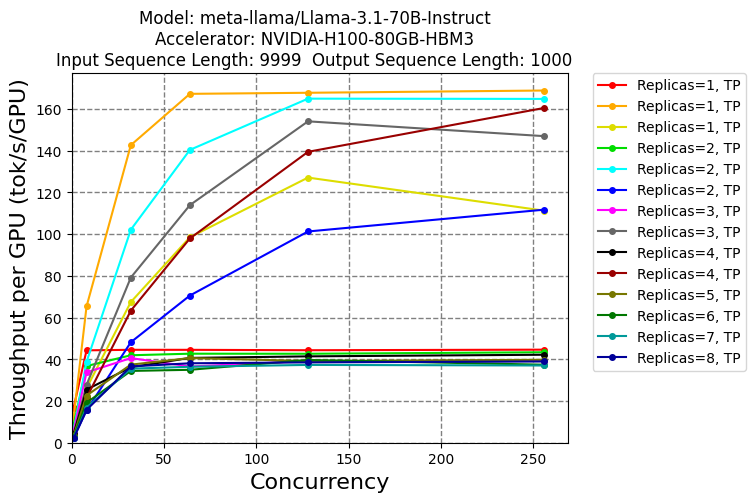

In [4]:
################################################################################
# User inputs
################################################################################

# Select index of scenario
idx = 238

# Configuration keys to group
#config_keys = ['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP']
config_keys = ['Replicas', 'TP']

# Segregate traces by column
col_seg_by='Directory_Base'

# Columns for axes
col_x = 'Max_Concurrency'
col_y = 'Thpt_per_GPU'

# Select linear or log scales
log_x = False
log_y = False

################################################################################
# User inputs
################################################################################

plot_scenario(
    runs_df=runs,
    scenario=scenarios[idx],
    config_keys=config_keys,
    col_x=col_x,
    col_y=col_y,
    col_seg_by=col_seg_by,
    log_x=log_x,
    log_y=log_y)

### Plot tradeoff between two metrics across configurations

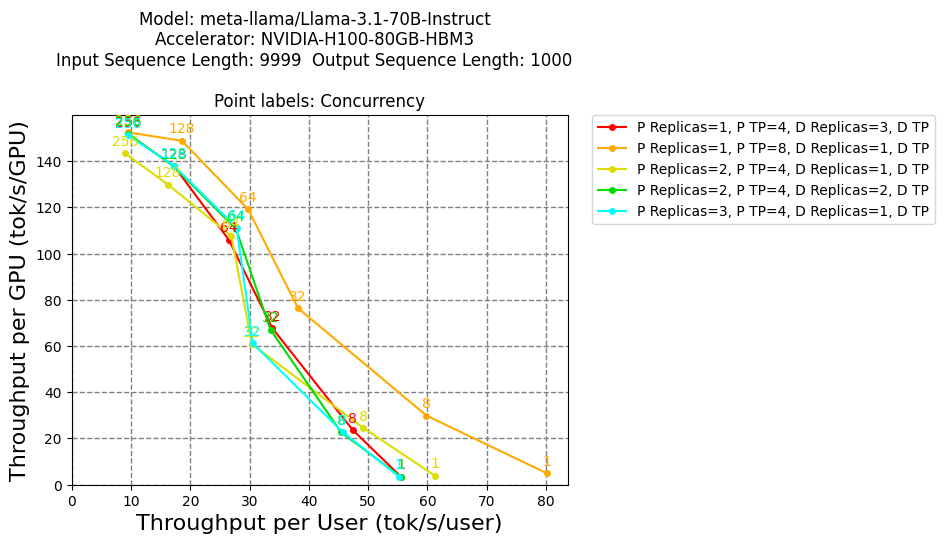

In [5]:
################################################################################
# User inputs
################################################################################

# Select index of scenario
idx = 238

# Configuration keys to group
config_keys = ['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP']
#config_keys = ['Replicas', 'TP']

# Segregate traces by column
col_seg_by='Directory_Base'

# Columns for axes
col_x = 'Thpt_per_User'
col_y = 'Thpt_per_GPU'
# The "Z" axis will be numerical printouts above each point
col_z = 'Max_Concurrency'

# Select linear or log scales
log_x = False
log_y = False

################################################################################
# Standard code
################################################################################

plot_scenario_tradeoff(
    runs_df=runs,
    scenario=scenarios[idx],
    config_keys=config_keys,
    col_x=col_x,
    col_y=col_y,
    col_z=col_z,
    col_seg_by=col_seg_by,
    log_x=log_x,
    log_y=log_y)

### Examine Pareto front

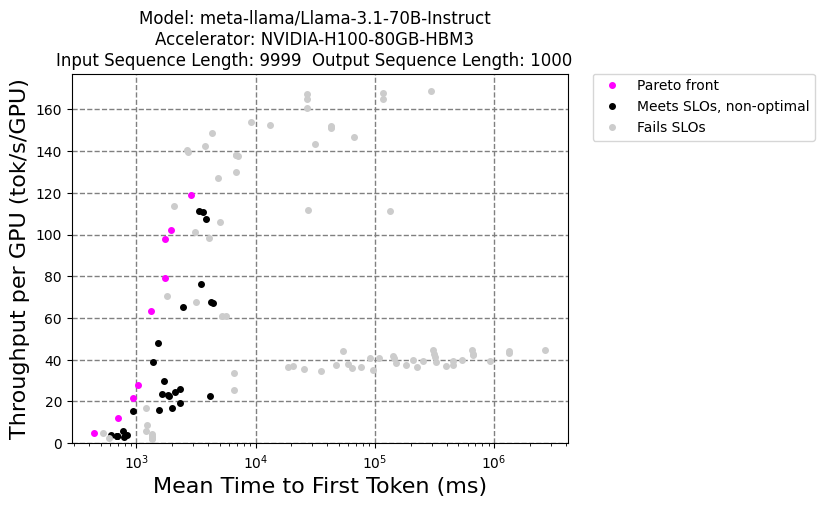

,Replicas,TP,P_Replicas,P_TP,D_Replicas,D_TP,Mean_TTFT_ms,Thpt_per_GPU
97,None,None,1,8,1,8,443.145233,5.004825
10,1,4,None,None,None,None,697.070646,12.089005
52,4,4,None,None,None,None,933.162118,21.506293
102,3,4,None,None,None,None,1022.750448,27.733967
51,4,4,None,None,None,None,1326.108478,63.336966
105,3,4,None,None,None,None,1737.971209,79.192130
49,4,4,None,None,None,None,1751.802189,97.933493
68,2,4,None,None,None,None,1951.305972,102.133217
98,None,None,1,8,1,8,2874.809175,119.103707


In [6]:
################################################################################
# User inputs
################################################################################

# Select scenario
idx = 238

# Define SLOs
slos = [
    xp.SLO('P90_TTFT_ms', 10000),
    xp.SLO('P90_TPOT_ms', 50),
    xp.SLO('Total_Token_Throughput', 500),
]

# Columns for metrics of interest to optimize
#col_x = 'Thpt_per_User'
col_x = 'Mean_TTFT_ms'
col_y = 'Thpt_per_GPU'

# Select linear or log scales
log_x = True
log_y = False

# Configuration columns of interest
config_columns = ['Replicas', 'TP', 'P_Replicas', 'P_TP', 'D_Replicas', 'D_TP']

################################################################################
# Standard code
################################################################################

plot_pareto_tradeoff(
    runs_df=runs,
    scenario=scenarios[idx],
    col_x=col_x,
    col_y=col_y,
    slos=slos,
    log_x=log_x,
    log_y=log_y)

# Print table of optimal configurations
# Get scenario rows from all runs in dataset
runs_scenario = xp.get_scenario_df(runs, scenarios[idx])
# Get just the rows that meet SLOs
runs_meet_slo = xp.get_meet_slo_df(runs_scenario, slos)
# Get rows on Pareto front
runs_pareto_front = xp.get_pareto_front_df(runs_meet_slo, col_x, col_y, True)
# Print the rows on Pareto front, showing just the columns of interest
columns_of_interest = config_columns[:]
columns_of_interest.append(col_x)
columns_of_interest.append(col_y)
runs_pareto_front[columns_of_interest]

## Inference Scheduler Configuration Exploration

In [9]:
################################################################################
# User inputs
################################################################################

# Scenario columns
scenario_columns = ['Model', 'GPU', 'System_Prompt_Length', 'Question_Length', 'OSL_500', 'Groups', 'Prompts_Per_Group']

# Minimum number of datapoints a scenario must have (otherwise ignore)
min_count = 10

################################################################################
# Standard code
################################################################################
from typing import Any
import pandas as pd

scenarios = xp.get_scenarios(runs, scenario_columns)
xp.print_scenarios(scenarios, runs, min_count)

IDX  Count  Model            GPU                    System_Prompt_Length  Question_Length  OSL_500  Groups  Prompts_Per_Group  
0    49     Qwen/Qwen3-0.6B  NVIDIA-H100-80GB-HBM3  2048                  1000             750      32      32                 
1    98     Qwen/Qwen3-0.6B  NVIDIA-H100-80GB-HBM3  2048                  300              250      32      32                 
2    49     Qwen/Qwen3-0.6B  NVIDIA-H100-80GB-HBM3  2048                  300              750      32      32                 
3    98     Qwen/Qwen3-0.6B  NVIDIA-H100-80GB-HBM3  2048                  100              250      32      32                 
4    49     Qwen/Qwen3-0.6B  NVIDIA-H100-80GB-HBM3  2048                  100              750      32      32                 
5    98     Qwen/Qwen3-0.6B  NVIDIA-H100-80GB-HBM3  2048                  1000             250      32      32                 


### Plot metric of interest across configurations

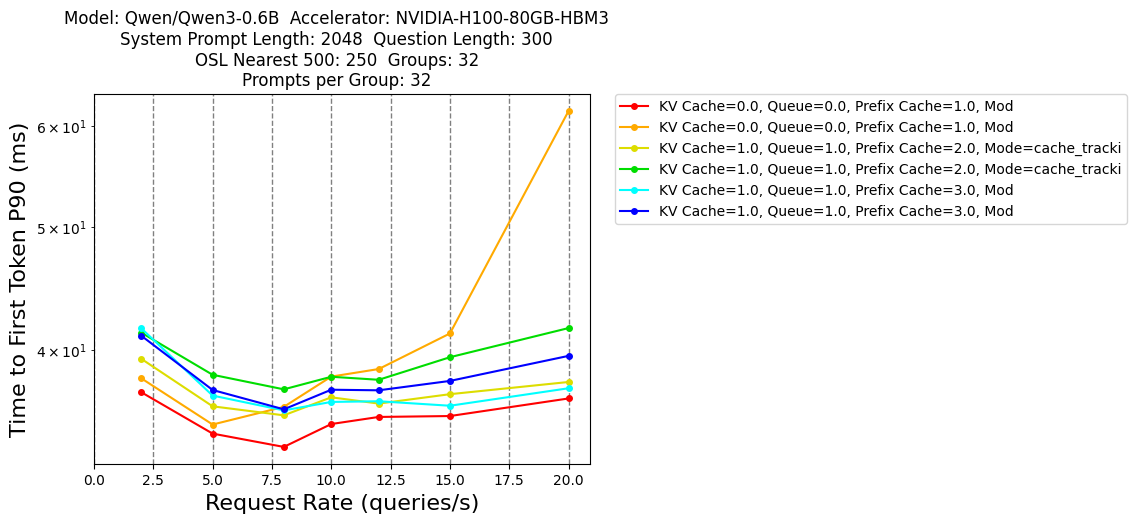

In [16]:
################################################################################
# User inputs
################################################################################

# Select index of scenario
idx = 1

# Configuration keys to group
config_keys = ['KV_Cache_Scorer_Weight', 'Queue_Scorer_Weight', 'Prefix_Cache_Scorer_Weight', 'Prefix_Cache_Scorer_Mode']

# Segregate traces by column
col_seg_by='Directory'

# Columns for axes
col_x = 'Max_QPS'
col_y = 'P90_TTFT_ms'
#col_y = 'Failures'

# Select linear or log scales
log_x = False
log_y = True

################################################################################
# User inputs
################################################################################

plot_scenario(
    runs_df=runs,
    scenario=scenarios[idx],
    config_keys=config_keys,
    col_x=col_x,
    col_y=col_y,
    col_seg_by=col_seg_by,
    log_x=log_x,
    log_y=log_y)

### Plot tradeoff between two metrics across configurations

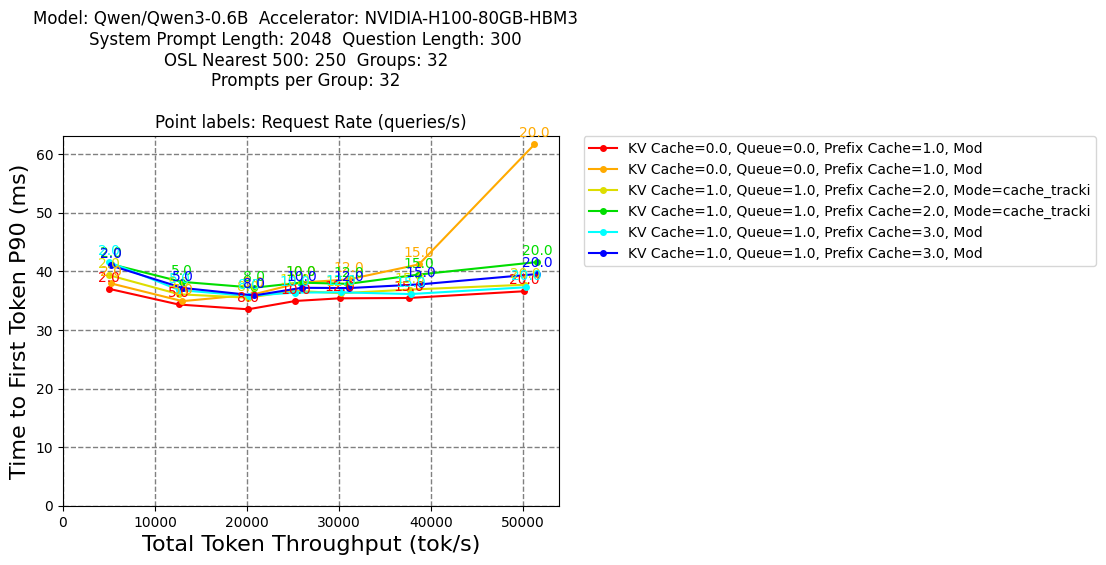

In [15]:
################################################################################
# User inputs
################################################################################

# Select index of scenario
idx = 1

# Configuration keys to group
config_keys = ['KV_Cache_Scorer_Weight', 'Queue_Scorer_Weight', 'Prefix_Cache_Scorer_Weight', 'Prefix_Cache_Scorer_Mode']

# Segregate traces by column
col_seg_by='Directory'

# Columns for axes
col_x = 'Total_Token_Throughput'
col_y = 'P90_TTFT_ms'
# The "Z" axis will be numerical printouts above each point
col_z = 'Max_QPS'

# Select linear or log scales
log_x = False
log_y = False

################################################################################
# Standard code
################################################################################

plot_scenario_tradeoff(
    runs_df=runs,
    scenario=scenarios[idx],
    config_keys=config_keys,
    col_x=col_x,
    col_y=col_y,
    col_z=col_z,
    col_seg_by=col_seg_by,
    log_x=log_x,
    log_y=log_y)